# Численное исследование методов восстановления PH-распределений

В этом ноутбуке рассмотрим два метода восстановления PH-распределений:

- построение канонических ациклических распределений ACPH(2) [1]
- поиск гиперэрланговских распределений с двумя цепями одного порядка MEn(2) [2]

*[1] Telek, Miklós & Heindl, Armin. (2003). Matching Moments For Acyclic 
Discrete And Continuous Phase-Type Distributions Of Second Order. 
International Journal of Simulation Systems, Science & Technology. 3.*

*[2] Mary A. Johnson & Michael R. Taaffe (1989) Matching moments to phase
distributions: Mixtures of erlang distributions of common order,
Communications in Statistics. Stochastic Models, 5:4, 711-743,
DOI: 10.1080/15326348908807131*

## Подготовка ноутбука

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from itertools import product
from tqdm.notebook import tqdm
from typing import Union, Sequence
import os

from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, \
    get_noncentral_m3
from pyqumo.fitting.acph2 import get_acph2_m2_min, get_acph2_m3_bounds
from pyqumo.random import HyperErlang
from pyqumo.utils.plots import get_color

from utility.jupyter_helpers import setup_matplotlib, get_color, savefig, \
    LIGHT_CMAP, DARK_CMAP

In [4]:
# Настраиваем matplotlib
%matplotlib inline
setup_matplotlib()
BG_CMAP = LIGHT_CMAP
FG_CMAP = DARK_CMAP

## Параметры окружения и вспомогательные функции

При построении распределений по трем моментам будем полагать, что среднее значение равно
единице, а второй и третий моменты будем задавать через нормализованные величины:

- $c$ - коэффициент вариации
- $\gamma$ - коэффициент асимметрии

Вычисления будем проводить на плоскости $(c-1/c, \gamma)$, как это было предложено
в работе Johnoson et. al. [2].

In [5]:
def x2cv(x: float) -> float:
    """Get CV value from c-1/c value.
    """
    return (x + pow(x**2 + 4, 0.5)) / 2

In [6]:
GRID_SIZE = 100
X = np.linspace(-10, 10, GRID_SIZE)  # c - 1/c values
Y = np.linspace(-10, 10, GRID_SIZE)  # gamma (skewness) values, not all feasible
CV = np.asarray([x2cv(x) for x in X])
PLANE_SHAPE = (GRID_SIZE, GRID_SIZE)
COORDS = list(product(range(GRID_SIZE), range(GRID_SIZE)))
MEAN = 1.0

## Области существования ACPH(2)

Метод, предложенный в работе [1], позволяет очень быстро находить PH-распределения второго порядка.
К сожалению, метод работает не для любых значений $c$ и $\gamma$. 

Область существования ACPH(2) удобно определять на плоскости $(c-1/c, \gamma)$.

In [7]:
# M2 = [get_noncentral_m2(MEAN, cv) for cv in CV]

Saving figure


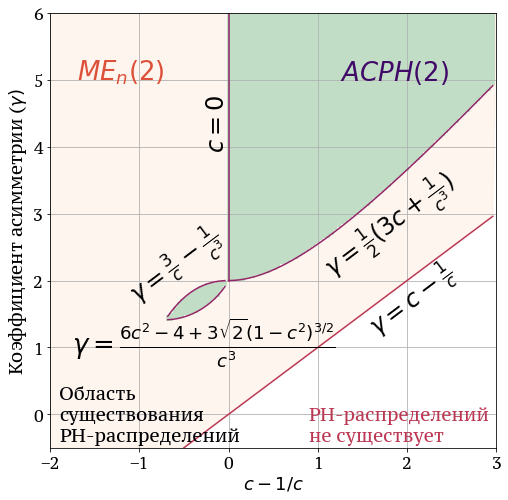

In [8]:
def plot_acph2_boundary_in_normal_plane(
        mean: float = 1, step: float = 0.002, scale: float = 1.0, 
        image_name: str = ""
):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    xmin = -2.0
    xmax = 3
    ymin = -0.5
    ymax = 6
    
    X = np.arange(xmin, xmax, step)  # cv - 1/cv
    Y = np.arange(ymin, ymax, step)  # skew
    CV = np.asarray([x2cv(x) for x in X])
    F = np.zeros((len(Y), len(X)))
    
    m2_min = get_acph2_m2_min(mean)
    cv_min = get_cv(mean, m2_min)
    x_min = cv_min - 1/cv_min
    
    Xs = np.asarray([x for x in X if x_min <= x <= 0])
    Cs = np.asarray([x2cv(x) for x in Xs])
    G1 = (6*Cs**2 - 4 + 3 * 2**0.5 * (1 - Cs**2)**1.5) / Cs**3
    G2 = 3/Cs - 1/Cs**3
    
    Xl = np.asarray([x for x in X if x >= 0])
    Cl = np.asarray([x2cv(x) for x in Xl])
    G3 = 1.5*Cl + 0.5/Cl**3
    
    Xv = [0, 0]
    G4 = [2, ymax]  # constant: lowest point states for Exp dist.

    for i, x in enumerate(X):
        cv = CV[i]
        m2 = get_noncentral_m2(mean, cv)
        if m2 < m2_min:
            for j in range(len(Y)):
                F[j, i] = np.nan
            continue
        min_m3, max_m3 = get_acph2_m3_bounds(mean, m2)
        for j, y in enumerate(Y):
            m3 = get_noncentral_m3(mean, cv, y)
            F[j, i] = 1 if min_m3 <= m3 <= max_m3 else np.nan

    ax.pcolormesh(X, Y, F, cmap=BG_CMAP)
    ax.plot(Xs, G1, color=FG_CMAP(.4))
    ax.plot(Xs, G2, color=FG_CMAP(.4))
    ax.plot(Xl, G3, color=FG_CMAP(.4))
    ax.plot(Xv, G4, color=FG_CMAP(.4))
    
    boundary = [max(X[0], Y[0]), min(X[-1], Y[-1])]
    ax.plot(boundary, boundary, color=get_color(0.5))
    ax.fill(
        [xmin, min(boundary), max(boundary), xmax, xmin],
        [ymin, min(boundary), max(boundary), ymax, ymax],
        color=BG_CMAP(0.2), alpha=0.2
    )
    
    ax.text(-2.5 * scale, 0.9, 
            r'$\gamma = \frac{6c^2 - 4 + 3\sqrt{2}(1-c^2)^{3/2}}{c^3}$', 
            fontsize=26, rotation=0)
    ax.text(-1.7 * scale, 1.7, r'$\gamma = \frac{3}{c} - \frac{1}{c^3}$', 
            fontsize=24, rotation=37)
    ax.text(-0.25, 4.0, r'$c = 0$', rotation=90, fontsize=24)
    ax.text(1.0, 2.1, r'$\gamma = \frac{1}{2}(3c + \frac{1}{c^3})$', 
            fontsize=24, rotation=37)
    ax.text(1.5, 1.2, r'$\gamma = c - \frac{1}{c}$', fontsize=24, rotation=37)
    ax.text(xmin + 0.1, ymin + 0.1, 'Область\nсуществования\nPH-распределений', 
            fontsize=18, color=get_color(0.0))
    ax.text(xmax - 3.0 * scale, ymin + 0.1, 'PH-распределений\nне существует', 
            fontsize=18, color=get_color(0.5))
    ax.text(xmin + 0.3, ymax - 1.0, r'$ME_n(2)$', fontsize=26, 
            color=FG_CMAP(0.6))
    ax.text(xmax - 2.5 * scale, ymax - 1.0, r'$ACPH(2)$', fontsize=26, 
            color=FG_CMAP(0.2))
    
    ax.grid()
    ax.set_xlabel(r'$c - 1/c$', fontsize=18)
    ax.set_ylabel(r'Коэффициент асимметрии ($\gamma)$', fontsize=18)
    ax.tick_params(labelsize=16)
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    
    print("Saving figure")
    savefig(image_name)

plot_acph2_boundary_in_normal_plane(
    step=0.04, scale=0.7, image_name="ch4_feasible_regions")

## Исследование порядка распределений $ME_n(2)$

As in paper [1], we will study the performance on the $(c-1/c, \gamma)$ plane, where $c$ is a coefficient of variation.

Note that equation $c - 1/c = x$ always have a single solution for $c > 0$:

$$
c - 1/c = x \; \Leftrightarrow \; c^2 - xc - 1 = 0 \Leftrightarrow c = \frac{x + \sqrt{x^2 + 4}}{2}
$$

In [9]:
raw_dists = [[
    fit_mern2([MEAN, get_noncentral_m2(MEAN, cv),
              get_noncentral_m3(MEAN, cv, y)])[0]
    if y > x else None for (x, cv) in zip(X, CV)
] for y in tqdm(Y)]

  0%|          | 0/100 [00:00<?, ?it/s]

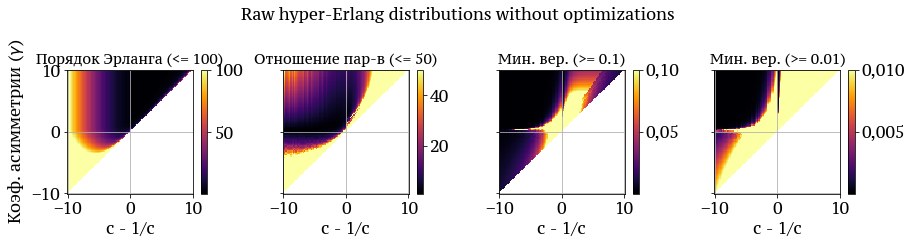

In [10]:
def plot_dist_params(distributions, title="", y_size=5):
    orders = np.zeros(shape=PLANE_SHAPE)
    min_p_1 = np.zeros(shape=PLANE_SHAPE)
    min_p_2 = np.zeros(shape=PLANE_SHAPE)
    max_ratio = np.zeros(shape=PLANE_SHAPE)
    for (i, j) in COORDS:
        dist = distributions[i][j]
        if dist is None:
            orders[i][j] = np.nan
            min_p_1[i][j] = np.nan
            min_p_2[i][j] = np.nan
            max_ratio[i][j] = np.nan
            continue
        assert isinstance(dist, HyperErlang)
        params = dist.params
        orders[i][j] = min(dist.order/2, 100)
        min_p_1[i][j] = min(min([p for p in dist.probs if p > 0]), 0.1)
        min_p_2[i][j] = min(min([p for p in dist.probs if p > 0]), 0.01)
        max_ratio[i][j] = min(max(params) / min(params), 50)

    fig, (ax1, ax2, ax3, ax4) = \
        plt.subplots(figsize=(13, y_size), ncols=4, nrows=1, sharey=True)
    im1 = ax1.pcolormesh(X, Y, orders)
    im2 = ax2.pcolormesh(X, Y, max_ratio)
    im3 = ax3.pcolormesh(X, Y, min_p_1)
    im4 = ax4.pcolormesh(X, Y, min_p_2)
    fig.suptitle(title, fontsize=16) 
    ax1.set_title('Порядок Эрланга (<= 100)', fontsize=14)
    ax2.set_title('Отношение пар-в (<= 50)', fontsize=14)
    ax3.set_title('Мин. вер. (>= 0.1)', fontsize=14)
    ax4.set_title('Мин. вер. (>= 0.01)', fontsize=14)
    ax1.set_ylabel('Коэф. асимметрии ' + r"($\gamma$)")
    for im, ax in zip((im1, im2, im3, im4), (ax1, ax2, ax3, ax4)):
        fig.colorbar(im, ax=ax)
        ax.set_xlabel('c - 1/c')
        ax.grid()
    plt.tight_layout()    

#
# Plot original hyper-Erlang distributions without optimizations of ratios or probabilities.
#
plot_dist_params(raw_dists, "Raw hyper-Erlang distributions without optimizations", y_size=3.5)

В некоторых случаях можно улучшить полученное распределение - сделать больше минимальную вероятность цепи и уменьшить отношение большего параметра к меньшему, если немного увеличить длину цепи.

В следующем эксперименте посмотрим, как меняется отношение параметров и минимальная вероятность.

In [11]:
MAX_INC = [2, 5, 10, 20, 30]
opt_ratio_dists = [[[
    fit_mern2(
        [MEAN, get_noncentral_m2(MEAN, cv), get_noncentral_m3(MEAN, cv, y)], 
        max_shape_inc=inc
    )[0]
    if y > x else None for (x, cv) in zip(X, CV)
] for y in Y] for inc in tqdm(MAX_INC)]

  0%|          | 0/5 [00:00<?, ?it/s]

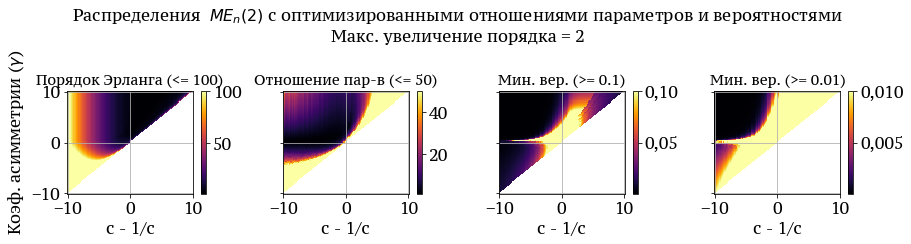

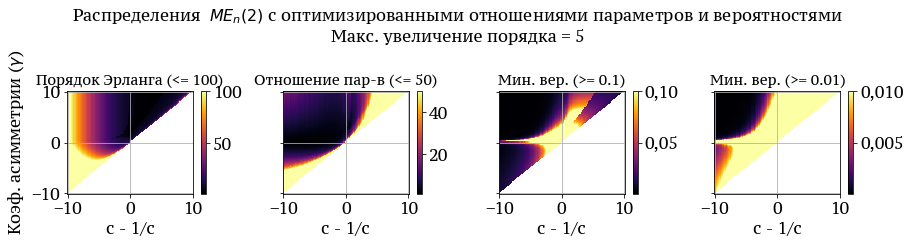

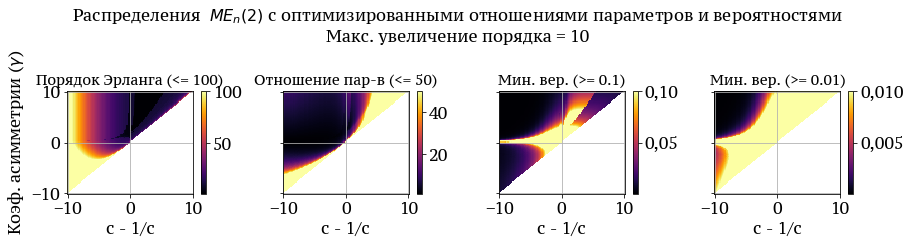

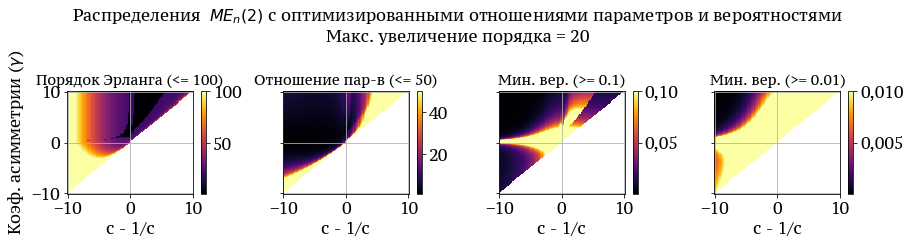

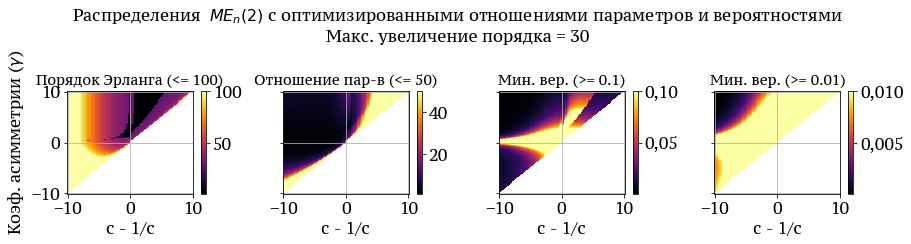

In [12]:
for i, inc in enumerate(MAX_INC):
    plot_dist_params(
        opt_ratio_dists[i], 
        (f"Распределения " + r" $ME_n(2)$ " + 
         f"с оптимизированными отношениями параметров и вероятностями\n"
         f"Макс. увеличение порядка = {inc}"),
        y_size=3.5)